In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Tue May  3 13:36:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q ogb

In [ ]:
# Import modules
import networkx as nx
from torch_geometric.utils.convert import to_networkx

from tqdm import tqdm
import time
import sys
import os
import math
import random

import torch.nn.functional as F

import numpy as np

import pandas as  pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

## The dataset

In [ ]:
'''
The Flickr dataset from the “GraphSAINT: Graph Sampling Based Inductive Learning
Method” paper, containing descriptions and common properties of images.
'''
# from torch_geometric.datasets import Flickr
# dataset = Flickr(root="datasets")

'\nThe Flickr dataset from the “GraphSAINT: Graph Sampling Based Inductive Learning\nMethod” paper, containing descriptions and common properties of images.\n'

In [ ]:
'''
The Reddit dataset from the “GraphSAINT: Graph Sampling Based Inductive Learning
Method” paper, containing Reddit posts belonging to different communities.
'''
from torch_geometric.datasets import Reddit2
dataset = Reddit2(root="datasets")

In [ ]:
'''
The Amazon dataset from the “GraphSAINT: Graph Sampling Based Inductive
Learning Method” paper, containing products and its categories.
'''
# from torch_geometric.datasets import AmazonProducts
# dataset = AmazonProducts(root="datasets")

'\nThe Amazon dataset from the “GraphSAINT: Graph Sampling Based Inductive\nLearning Method” paper, containing products and its categories.\n'

In [ ]:
data = dataset[0]

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.AddSelfLoops()])
data = transform(data)

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Reddit2():
Number of graphs: 1
Number of features: 602
Number of classes: 41

Data(x=[232965, 602], edge_index=[2, 23446803], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])
Number of nodes: 232965
Number of edges: 23446803
Average node degree: 100.65
Number of training nodes: 153932
Training node label rate: 0.661
Has isolated nodes: True
Has self-loops: True
Is undirected: True


---


Choose one of the training data loader below:

In [ ]:
'''
The GraphSAINT sampler base class from the “GraphSAINT: Graph Sampling Based
Inductive Learning Method” paper. Given a graph in a data object, this class
samples nodes and constructs subgraphs that can be processed in a mini-batch fashion.
'''
from torch_geometric.loader import GraphSAINTRandomWalkSampler
loader = GraphSAINTRandomWalkSampler(
    data, batch_size=512, walk_length=2,
    num_steps=100,
    save_dir=dataset.processed_dir,
    num_workers=12
)

---

In [ ]:
'''
ClusterData Clusters/partitions a graph data object into multiple subgraphs.
ClusterLoader merges partioned subgraphs and their between-cluster links from
a large-scale graph data object to form a mini-batch.

Note: requires too much RAM memory to run for AmazonProducts on Colab
'''
from torch_geometric.loader import ClusterData, ClusterLoader
cluster_data = ClusterData(
    data,
    num_parts=1500,
    recursive=False,
    save_dir=dataset.processed_dir
)
loader = ClusterLoader(
    cluster_data,
    batch_size=32,
    shuffle=True,
    num_workers=12)

---

In [ ]:
'''
NeighborLoader allows for mini-batch training of GNNs on large-scale graphs
where full-batch training is not feasible.
More specifically, num_neighbors denotes how much neighbors are sampled for
each node in each iteration.
NeighborLoader takes in this list of num_neighbors and iteratively samples
num_neighbors[i] for each node involved in iteration i - 1.
'''
from torch_geometric.loader import NeighborLoader, ImbalancedSampler
sampler = ImbalancedSampler(
    data,
    input_nodes=data.train_mask
)
loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    batch_size=512,
    num_neighbors=[-1], # to sample all neighbors
    sampler=sampler
)

---

In [ ]:
batch_data_sample = next(iter(loader))
print(f'Batch sample: {batch_data_sample}')
print(f'Num of iterations per eppch: {len(loader)}')

Batch sample: Data(x=[40914, 602], edge_index=[2, 55550], y=[40914], train_mask=[40914], val_mask=[40914], test_mask=[40914], batch_size=512)
Num of iterations per eppch: 301


---

The graph loader used in the evaluation phase:

In [ ]:
'''
NeighborSampler iteratively samples neighbors and constructs bipartite graphs
that simulate the actual computation flow of GNNs.
More specifically, sizes denotes how much neighbors we want to sample for each node in each layer.
Hence, an item returned by NeighborSampler holds the current batch_size, the IDs
n_id of all nodes involved in the computation, and a list of bipartite graph objects
via the tuple (edge_index, e_id, size), where edge_index represents the bipartite edges
between source and target nodes, e_id denotes the IDs of original edges in the full graph,
and size holds the shape of the bipartite graph. For each bipartite graph,
target nodes are also included at the beginning of the list of source nodes
so that one can easily apply skip-connections or add self-loops.
'''
from torch_geometric.loader import NeighborSampler
subgraph_loader = NeighborSampler(
    data.edge_index,
    node_idx=None,
    sizes=[-1],
    batch_size=512,
    shuffle=False,
    num_workers=12
)

In [ ]:
X = data.x.to(device)

# Model Definition

**GATv2**

Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [ ]:
from torch_geometric.nn.conv import GATv2Conv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class ParametrizedGATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(ParametrizedGATNet, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            in_dim = hid_dim * n_heads
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GATv2Conv(in_dim, out_dim, heads=n_heads, concat=False)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = x + x_prev
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction
    
    def inference(self, x_all):
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        x_prev = None
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x_prev = x[:size[1]]

                x = conv((x, x_target), edge_index)
                x = bn(x)

                if self.skip_conn and i != 0 and i != self.n_layers-1:
                    x = x + x_prev
            
                x = F.relu(x)

                xs.append(x.cpu())
            
            x_all = torch.cat(xs, dim=0)
            
            
        if self.post_proc_MLP:
            x_all = self.post_MLP(x_all.to(device))

        return x_all.cpu()

# Train and Evaluation

In [ ]:
def train(model, optimizer):
    model.train()

    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index)
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
        total_examples += batch.num_nodes
    return total_loss / total_examples

In [ ]:
@torch.no_grad()
def test(model):
    model.eval()

    out = model.inference(X)

    y_true = data.y
    y_pred = out.argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = y_pred[mask].eq(y_true[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

In [ ]:
def train_eval(model, optimizer, trials=1, epochs=20):

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None

    best_test_acc = 0

    for trial in range(trials):

        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['train_loss'] = []
        history['train_acc'] = []
        history['val_acc'] = []
        history['test_acc'] = []
        
        pbar = tqdm(range(epochs))
        for epoch in pbar:

            loss = train(model, optimizer)

            accs = test(model)

            description = f'Epoch: {epoch+1:02d}, Train loss: {loss:.4f}, Train acc: {accs[0]:.4f}, Val acc: {accs[1]:.4f}, Test acc: {accs[2]:.4f}'
            pbar.set_description(description, refresh=True)

            history['train_loss'].append(loss)
            history['train_acc'].append(accs[0])
            history['val_acc'].append(accs[1])
            history['test_acc'].append(accs[2])

            
            last_test_acc = history['test_acc'][-1]
            if last_test_acc > best_test_acc:
                best_test_acc = last_test_acc
                best_model_weights = model.state_dict()
                best_model_history = history

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    print(f'\nBest model with test acc: {best_test_acc:.4f}')
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights

In [ ]:
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 50
NTRIALS = 1
LR = 1e-3
WD = 0 # 1e-5

best_test_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.5],
    'N_LAYERS' : [3],
    'N_HEADS' : [3],
    'SKIP_CONN' : [True],
    'POST_PROC_MLP' : [False, True]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    #criterion = torch.nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights = train_eval(model, optimizer, trials=NTRIALS, epochs=EPOCHS)
    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

With GraphSAINTSamplet

With NeighborLoader

In [ ]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.5, 'HIDDEN_DIM': 16, 'N_HEADS': 3, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}

Best model predicts with 82.26% accuracy on test set


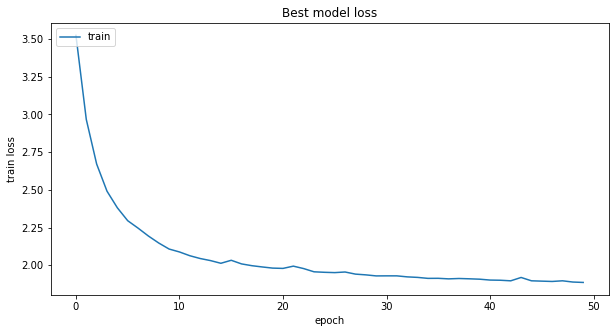

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_loss'], label='train')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('train loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

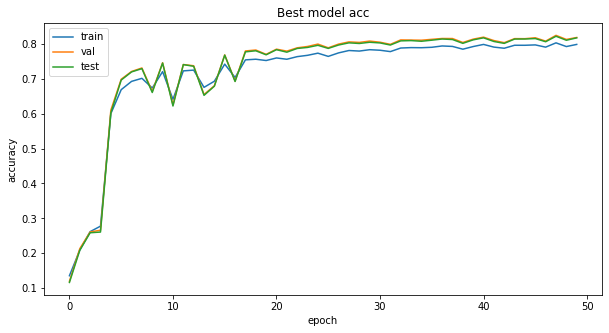

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.plot(best_model_history['test_acc'], label='test')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

#Train and evaluate ML models

In [ ]:
data = dataset[0]  # Get the first graph object.

## Main ML models tuning
In this section are evaluated the performance of some ML models to see the real improvement in using a GNN model.

Also in this case a fine tuning is performed to evaluate only the best configuration of parameters for each model.

In [ ]:
# X_train and X_test contains the node features
# X_train combines both train and validation splits in order to perform crossvalidation
X_train = pd.DataFrame(data.x[data.train_mask].detach().numpy())
#X_train = X_train.append(pd.DataFrame(data.x[data.val_mask].detach().numpy()))
X_test = pd.DataFrame(data.x[data.test_mask].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

X_train	shape: (153932, 602)
X_test	shape: (55334, 602)


In [ ]:
# y_train and y_test contains the node labels
y_train = data.y[data.train_mask].detach().numpy().reshape(-1,)
#y_train = np.append(y_train, pd.DataFrame(data.y[data.val_mask].detach().numpy().reshape(-1,)))
y_test = data.y[data.test_mask].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

y_train	shape: (153932,)
y_test	shape: (55334,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Labels for the models
model_lbls = [
    'lr',   # Logistic Regressor
    'rf',   # Random Forest
    'xgb',  # eXtreme Gradient Boost
]

# Set the parameters to be explored for each classifier
tuned_param_lr = [
    {
        'solver': ['lbfgs'],
    },
]
tuned_param_rf = [
    {
        'max_depth': [100],
    },
]
tuned_param_xgb = [
    {
        'objective': ['multi:softmax'],
        'tree_method': ['gpu_hist'],
    },
]

# Set the models to be fitted specifying name, estimator and parameter structure
models = {
    'lr': {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'param': tuned_param_lr,
    },
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(), 
        'param': tuned_param_rf,
    },
    'xgb':{
        'name': 'XGBoost',
        'estimator': XGBClassifier(),
        'param': tuned_param_xgb,
    }
}

# Scores to be explored
scores = [
    'precision', 
#    'recall',
]

In [ ]:
def print_results(model):    
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    best_score = 0
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))
        if mean > best_score:
          best_score = mean
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    y_pred = model.predict(X_test)
    print(f'Accuracy on test: {accuracy_score(y_test, y_pred)*100:.2f}%')
    return best_score * 100

In [ ]:
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")